## Code for Autocorrelations

In [ ]:
import xarray as xr
import os
import numpy as np
import netCDF4 as nc
import pandas as pd
from scipy import stats 
from scipy.interpolate import griddata, RectBivariateSpline
import matplotlib.pyplot as plt 
import statistics
#import seaborn as sns
from tqdm.auto import tqdm 
import operator as op
import cartopy as cart
import matplotlib.ticker as mticker
#from mpl_toolkits.axes_grid1 import make_axes_locatable
import pyproj
#from mpl_toolkits.basemap import Basemap, interp
import matplotlib.colors as colors
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.stats import kstest, mannwhitneyu, ks_2samp
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import matplotlib.dates as mdates
import cartopy
import cartopy.feature as cfeature
from datetime import timedelta
import datetime

In [2]:
size = (15, 15)
longdis = 15
latdis = 15
resolution = '10m'

# Map generation Code
def generateMap(central_longitude=0):
    
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))
    ax.coastlines()
    gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator((range(-180, 180, longdis)))
    gl.ylocator = mticker.FixedLocator((range(-90, 90, latdis)))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    ax.add_feature(cart.feature.BORDERS)

In [3]:
%cd ERA5/precip_dailytotal
#first re-grid on 360x180 grid with 1x1 gridcells
yearly_precip_regridded = xr.open_dataset('precip_daily_total_1979-2019_regrid.nc', engine='netcdf4')
#yearly_precip_regridded

D:\RainHeatData\ERA5\precip_dailytotal


In [4]:
#convert ERA5 precipitation to mm
yearly_precip_regridded = yearly_precip_regridded.tp*1000

In [5]:
%cd ..
%cd humid_heat\regridded_daymeans

D:\RainHeatData\ERA5
D:\RainHeatData\ERA5\humid_heat\regridded_daymeans


In [6]:
all_tw_regridded = xr.open_dataset('TW_daily_max_1979-2020_daymean_regridded.nc', engine='netcdf4')
#all_tw_regridded

In [7]:
#ERA5 Northern Hemisphere
lats = np.argwhere((yearly_precip_regridded.lat.values >= 0) & (yearly_precip_regridded.lat.values <= 90))
lons = np.argwhere((yearly_precip_regridded.lon.values >= 0) & (yearly_precip_regridded.lon.values <= 360))
precip_data_N = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(0,90)) #yearly_precip_regridded
TW_data_N = all_tw_regridded.sel(lon = slice(0,360), lat=slice(0,90))

#Southern Hemisphere
#lats = np.argwhere((yearly_precip_regridded.lat.values >= -90) & (yearly_precip_regridded.lat.values <= 0))
#lons = np.argwhere((yearly_precip_regridded.lon.values >= 0) & (yearly_precip_regridded.lon.values <= 360))
#precip_data_S = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(-90,0)) #yearly_precip_regridded
#TW_data_S = all_tw_regridded.sel(lon = slice(0,360), lat=slice(-90,0))


In [8]:
june_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 6)
july_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 7)
august_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 8)
JJA_idx = np.concatenate([june_months, july_months, august_months])
JJA_idx

december_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 12)
january_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 1)
february_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 2)
DJF_idx = np.concatenate([december_months, january_months, february_months])

In [9]:
precip_data_JJA = precip_data_N.where(precip_data_N.time.dt.month.isin([6,7,8]),drop=True) #tp for ERA5, precip for NOAA
TW_data_JJA = TW_data_N.where(TW_data_N.time.dt.month.isin([6,7,8]),drop=True).TW

## 3 regions of focus
* Region 1: Southern Arizona:  NEW COORD: 32-37N, 243-248E
* Region 2: East James Bay to US-Canada Border: updated: 49-55N, 282-289 N
* Region 3: Calcutta & Dhaka: 22-24N, 87-90E
* Region 4 (supplemental): Morocco:  20-30N, 0-10E

In [52]:
### select area to average over ###
# REGIONALLY AVERAGED SELECTIONS

#lats = np.argwhere((yearly_precip_regridded.lat.values >= 32.5) & (yearly_precip_regridded.lat.values <= 34.5))
#lons = np.argwhere((yearly_precip_regridded.lon.values >= 289.5) & (yearly_precip_regridded.lon.values <= 293.5))

lon_1=282.5
lon_2=289.5
lat_1=49.5
lat_2=55.5

precip_data = precip_data_JJA.sel(lon =slice(lon_1-.1,lon_2+.1), lat=slice(lat_1-.1,lat_2+.1))
precip_data_year = precip_data_N.sel(lon =slice(lon_1-.1,lon_2+.1), lat=slice(lat_1-.1,lat_2+.1)).mean(dim=['lat','lon'])
TW_data = TW_data_N.sel(lon =slice(lon_1-.1,lon_2+.1), lat=slice(lat_1-.1,lat_2+.1)).TW.mean(dim=['lat','lon'])

In [53]:
### Daily Precip Anomalies ###
#daily average
precip_mean = precip_data.groupby('time.dayofyear').mean(dim='time')
#30 day rolling mean
precip_rolling = precip_data.rolling(time = 30, center = True).mean('time')
#anomaly
precip_data_anom = precip_data.groupby('time.dayofyear') - precip_rolling.groupby('time.dayofyear').mean(dim='time')

### Daily Max TW Anomalies ###
#daily average
TW_mean = TW_data.groupby('time.dayofyear').mean(dim='time')
#rolling mean
TW_rolling = TW_data.rolling(time = 30, center = True).mean('time')

#anomalies -- with 5 day smoothed climatology and without
TW_data = TW_data.groupby('time.dayofyear') - TW_rolling.groupby('time.dayofyear').mean(dim='time')

In [54]:
#90th percentile cutoffs for each variable
# for anomalies use variable_data
# for abs magnitude use variable_mean
percentile_cutoff_JJA = np.nanpercentile(np.squeeze(precip_data), q=90, axis=0)
TW_percentile_cutoff_JJA = np.nanpercentile(np.squeeze(TW_data), q=90, axis=0)

In [55]:
### percentile of wet days >1 mm for area averaged ###

raw_percentile_cutoff_JJA = np.zeros((precip_data_JJA.shape[1], precip_data_JJA.shape[2]))
precip_days=[]
rain_threshold = 1
for i in range(precip_data.shape[1]):
    
    for j in range(precip_data.shape[2]):
        
        precip_data_for_coordinate = precip_data[:,i,j]
        idx_norain = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) <= rain_threshold))
        precip_data_JJA_pc = precip_data_for_coordinate[~idx_norain] #this is still an xarray, all days for given coord that have precip>1mm rain
        raw_percentile_cutoff_JJA[i][j] = np.nanpercentile(precip_data_JJA_pc, q=90)
        idx_90 = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) > raw_percentile_cutoff_JJA[i][j])) # put into index array
        precip_90_pc = precip_data_for_coordinate[idx_90] # select precip anomalies for this index
        precip_90_idx = precip_90_pc.time.to_dataframe() # put into dataframe, list of dates

In [56]:
for index, row in precip_90_idx.iterrows():
            
    # Buffer before
    buffer = 5
    date_datetime = index
    #date_datetime = datetime.strptime(date,'%Y-%m-%d')
            #date_datetime = datetime.strptime(date,'%Y-%m-%d') #turn into datetime 
    for addition in range(-1*buffer, 0): #5 days before, put actual day
        backward = date_datetime + timedelta(days = addition)
        precip_days.extend([backward])
                
                #First day aka day of
    precip_days.extend([date_datetime])

    for addition in range(1, buffer+1): # 5 days after event
        forward = date_datetime + timedelta(days = addition)
        precip_days.extend([forward])
        
precip_days_list = list(precip_days)

In [57]:
### Select +5/-5 days of Precip data ### 

#precip_days_tp = precip_data.where(precip_data.time.isin(precip_days_list), drop=True)
#precip_days_tp = precip_data.sel(time=precip_days_list)
precip_days_tp = precip_data_year.sel(time=precip_days_list)

TW_days_tp = TW_data.sel(time=precip_days_list)

In [58]:
TW_days_tp

<xarray.DataArray 'TW' (time: 4279)>
array([-2.3814945 , -2.302002  ,  0.61981773, ..., -1.2278328 ,
       -5.083932  , -3.256093  ], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-06-17 1979-06-18 ... 2019-09-04
    dayofyear  (time) int64 168 169 170 171 172 173 ... 242 243 244 245 246 247

Text(0.5, 1.0, 'EJB')

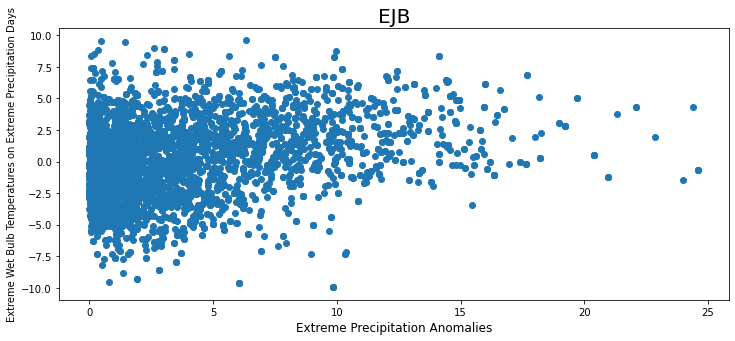

In [59]:
fig= plt.figure(figsize=(12,5))
plt.scatter(x=precip_days_tp, y=TW_days_tp, cmap='bwr')
plt.xlabel('Extreme Precipitation Anomalies', fontsize =12)
plt.ylabel('Extreme Wet Bulb Temperatures on Extreme Precipitation Days')
plt.title('EJB', fontsize =20)  

In [60]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

Text(0, 0.5, 'Correlation coefficient')

<Figure size 864x360 with 0 Axes>

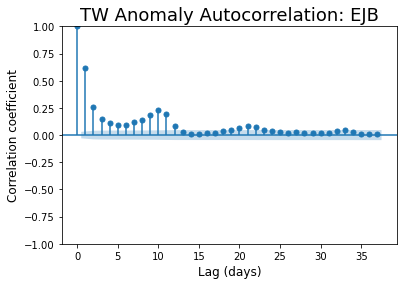

In [61]:
fig= plt.figure(figsize=(12,5))
tsaplots.plot_acf(TW_days_tp, alpha=.05)
                  #,lags=15)
plt.title("TW Anomaly Autocorrelation: EJB", fontsize =18)
plt.xlabel("Lag (days)", fontsize =12)
plt.ylabel("Correlation coefficient", fontsize =12)

#sm.tsa.acf(alb_TW_1998, nlags=15)

Text(0, 0.5, 'Correlation coefficient')

<Figure size 864x360 with 0 Axes>

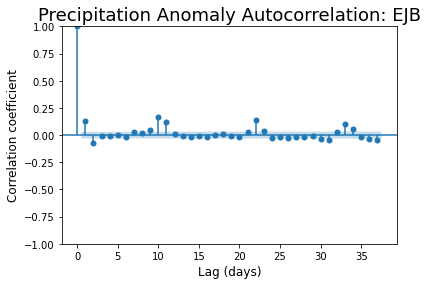

In [62]:
fig= plt.figure(figsize=(12,5))
tsaplots.plot_acf(precip_days_tp, alpha=.05)
                  #,lags=15)
plt.title("Precipitation Anomaly Autocorrelation: EJB", fontsize =18)
plt.xlabel("Lag (days)", fontsize =12)
plt.ylabel("Correlation coefficient", fontsize =12)

#sm.tsa.acf(alb_TW_1998, nlags=15)